[Official YOLOv7](https://github.com/WongKinYiu/yolov7)


In [1]:
import matplotlib.pyplot as plt
import torch
import cv2
import torchvision
from torchvision import transforms
import numpy as np
import time
import math

In [2]:
!pip -q install yolov7-package

In [3]:
!mkdir /content/yolov7-package
%cd /content/yolov7-package
!wget -q https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt

mkdir: cannot create directory ‘/content/yolov7-package’: File exists
/content/yolov7-package


In [4]:
from yolov7_package import Yolov7Detector
from yolov7_package.utils.datasets import letterbox
from yolov7_package.utils.general import non_max_suppression_kpt

In [5]:
def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def output_to_keypoint(output):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    targets = []
    for i, o in enumerate(output):
        kpts = o[:,6:]
        # print(f'nasif:: --> {kpts.shape}\n{kpts}')
        o = o[:,:6]
        for index, (*box, conf, cls) in enumerate(o.detach().cpu().numpy()):
            targets.append([i, cls, *list(*xyxy2xywh(np.array(box)[None])), conf, *list(kpts.detach().cpu().numpy()[index])])
    return np.array(targets)

def plot_skeleton_kpts(im, kpts, steps, orig_shape=None):
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

    skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
                [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
                [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
    # pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]
    pose_kpt_color = palette[[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]]

    radius = 5
    num_kpts = len(kpts) // steps

    for kid in range(num_kpts):
        r, g, b = pose_kpt_color[kid]
        x_coord, y_coord = kpts[steps * kid], kpts[steps * kid + 1]
        if not (x_coord % 640 == 0 or y_coord % 640 == 0):
            if steps == 3:
                conf = kpts[steps * kid + 2]
                if conf < 0.5:
                    continue
            cv2.circle(im, (int(x_coord), int(y_coord)), radius, (int(r), int(g), int(b)), -1)
            # print(f'{kid}, coord: {(int(x_coord), int(y_coord))}')

    for sk_id, sk in enumerate(skeleton):
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
        pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
        # print(f'{pos1}, {pos2}')
        # print(len(skeleton))
        if steps == 3:
            conf1 = kpts[(sk[0]-1)*steps+2]
            conf2 = kpts[(sk[1]-1)*steps+2]
            if conf1<0.5 or conf2<0.5:
                continue
        if pos1[0]%640 == 0 or pos1[1]%640==0 or pos1[0]<0 or pos1[1]<0:
            continue
        if pos2[0] % 640 == 0 or pos2[1] % 640 == 0 or pos2[0]<0 or pos2[1]<0:
            continue
        # print(f'Curated cordinate: {pos1}, {pos2}')
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=2)

## Detection of Multi-Person

Fusing layers... 


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


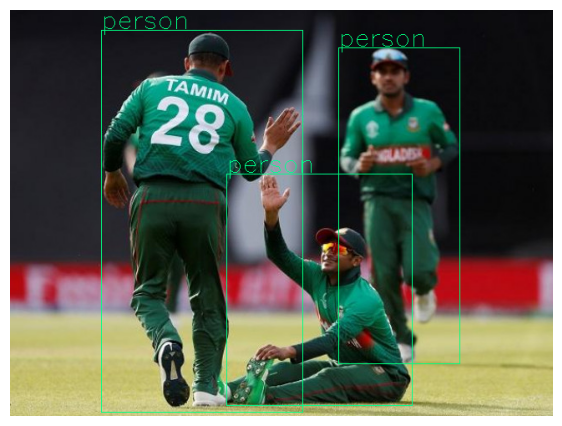

In [6]:
plt.figure(figsize=(7, 12))
image = plt.imread('/content/img.jpg')
det = Yolov7Detector(traced=False)
classes, boxes, scores = det.detect(image)
image = det.draw_on_image(image, boxes[0], scores[0], classes[0])
plt.imshow(image)
plt.axis('off')
plt.show()

## Render Multi_person's Pose

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('/content/yolov7-package/yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [8]:
image = cv2.imread('/content/img.jpg')
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)
output2, _ = model(image)



In [9]:
output2 = non_max_suppression_kpt(output2, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_keypoint(output2)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

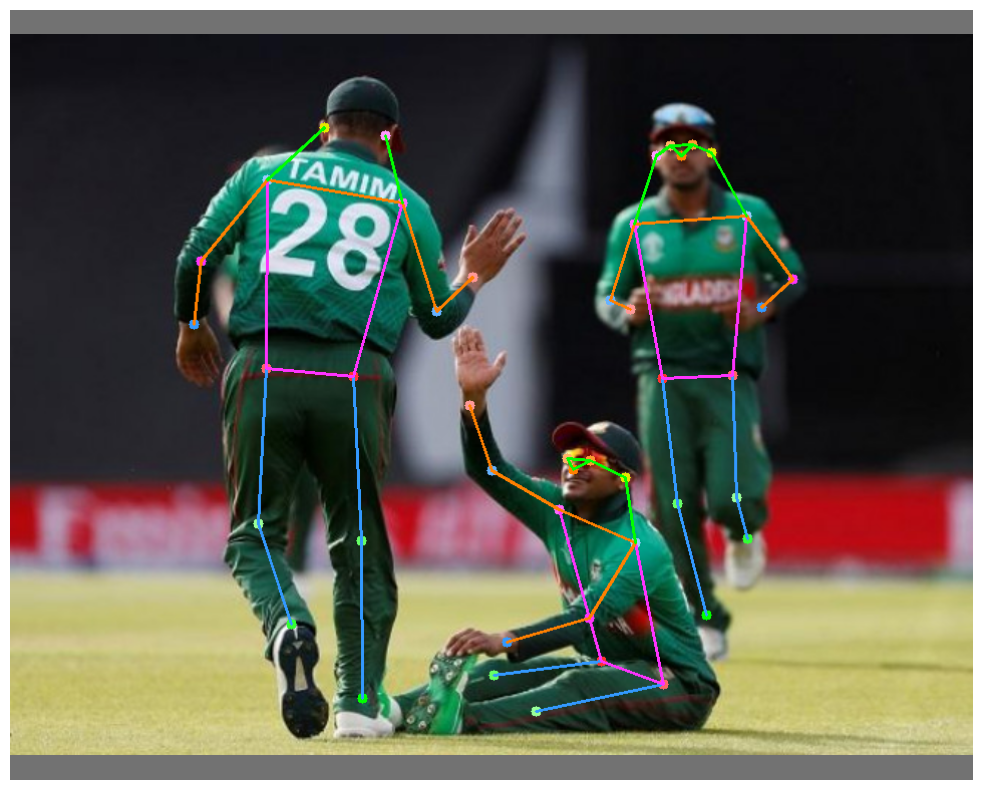

In [10]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(nimg)
plt.show()